In [235]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from termcolor import colored

In [2]:
env = gym.make('LunarLander-v2')

[2017-09-16 18:07:05,792] Making new env: LunarLander-v2


In [17]:
print(env.observation_space.shape)
print(env.action_space.n)

(8,)
4


In [10]:
s = env.reset()
for i in range(500):
    env.render()
    new_s, r, done, _ = env.step(env.action_space.sample())
    if done:
        break
env.close()

In [303]:
class Agent():
    def __init__(self, epsilon, gamma, lr, batchsize, memory, epsilon_decay):
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batchsize = batchsize
        self.model = Sequential()
        self.model.add(Dense(64, input_dim=8, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(env.action_space.n, activation='linear'))
        self.model.compile(loss='mae', optimizer=Adam(lr))
        self.memory = deque(maxlen=memory)
    
    def getAction(self, state):
        if self.epsilon >= np.random.rand():
            return int(np.random.randint(low=0, high=4, size=1))
        else:
            return np.argmax(agent.model.predict(state.reshape(1, 8)))
    
    def getPolicy(self, state):
        return np.argmax(agent.model.predict(state.reshape(1, 8)))
    
    def remember(self, experience):
        self.memory.append(experience)
        
    def train(self):
        index = np.random.choice(len(self.memory), self.batchsize)
        minibatch = [self.memory[i] for i in index]
        for state, action, reward, next_state, done in minibatch:
            q_current = self.model.predict(state.reshape(1,8))
            if done:
                q_target = reward
            else:
                q_target = reward + self.gamma * np.max(self.model.predict(next_state.reshape(1, 8))[0])
            # print(q_current.shape)
            q_current[0][action] = q_target
            self.model.fit(x = state.reshape(1, 8), y = q_current, epochs=1, verbose = 0)
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay

In [304]:
agent = Agent(1, 0.99, 0.001, 64, 5000, 0.995)

In [305]:
episodes = 5000
t_max = 10000

rewards_list = []

for episode in range(episodes):
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = agent.getAction(s)
        next_s, r, done, _ = env.step(a)
        agent.remember([s,a,r,next_s,done])
        total_reward = total_reward + r
        s = next_s
        if done:
            break
    agent.train()
    rewards_list.append(total_reward)
    if total_reward<0:
        print(colored('episode:{0}, total_reward:{1}, epsilon:{2}'.format(episode+1, total_reward, agent.epsilon),'red'))
    else:
        print(colored('episode:{0}, total_reward:{1}, epsilon:{2}'.format(episode+1, total_reward, agent.epsilon),'green'))

episode:1, total_reward:-382.8485674716173, epsilon:0.999
episode:2, total_reward:-172.54395575138966, epsilon:0.998001
episode:3, total_reward:-153.26926814716012, epsilon:0.997002999
episode:4, total_reward:-241.76758589023308, epsilon:0.996005996001
episode:5, total_reward:-70.89543673978545, epsilon:0.995009990004999
episode:6, total_reward:-154.05821713472136, epsilon:0.994014980014994
episode:7, total_reward:-174.12457142121735, epsilon:0.993020965034979
episode:8, total_reward:-139.0536719683774, epsilon:0.9920279440699441
episode:9, total_reward:-312.2094661518362, epsilon:0.9910359161258742
episode:10, total_reward:-134.2612292783445, epsilon:0.9900448802097482
episode:11, total_reward:-100.60321040637822, epsilon:0.9890548353295385
episode:12, total_reward:-359.6139078840055, epsilon:0.988065780494209
episode:13, total_reward:-128.28248430827966, epsilon:0.9870777147137147
episode:14, total_reward:-279.0616490924757, epsilon:0.986090636999001
episode:15, total_reward:-330.138

KeyboardInterrupt: 

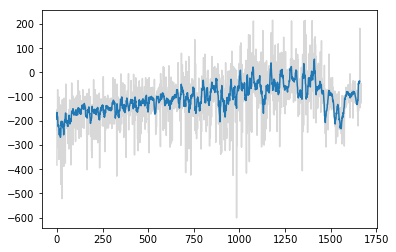

In [306]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_rews = running_mean(rewards_list, 10)

plt.plot(rewards_list, color='grey', alpha=0.3)
plt.plot(smoothed_rews)

In [284]:
s = env.reset()
total_reward = 0
for i in range(1000):
    env.render()
    new_s, r, done, _ = env.step(np.argmax(agent.model.predict(s.reshape(1, 8))))
    s = new_s
    total_reward = total_reward + r
    if done:
        print(total_reward)
        break
env.close()

-174.455633029
